<a href="https://colab.research.google.com/github/BachiLi/redner/blob/master/tutorials/camera_model_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This tutorial demonstrates the camera model of redner.

In [1]:
!pip install --upgrade redner-gpu

     |████████████████████████████████| 33.1MB 46.0MB/s 


In [2]:
# Tensorflow by default allocates all GPU memory, leaving very little for rendering.
# We set the environment variable TF_FORCE_GPU_ALLOW_GROWTH to true to enforce on demand
# memory allocation to reduce page faults.
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
%tensorflow_version 2.x
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import tensorflow_graphics.model.pyredner_tensorflow as pyredner

TensorFlow 2.x selected.


This time we will download the "conference" scene modelling a room in Lawrence Berkeley National Laboratory building, made by Anat Grynberg and Greg Ward in 1991. The model is hosted in Morgan McGuire's awesome [website](https://casual-effects.com/g3d/data10/index.html#mesh7).

In [0]:
import urllib
import zipfile
# wget
filedata = urllib.request.urlretrieve('https://casual-effects.com/g3d/data10/research/model/conference/conference.zip', 'conference.zip')
# unzip
zip_ref = zipfile.ZipFile('conference.zip', 'r')
zip_ref.extractall('conference/')

In [0]:
objects = pyredner.load_obj('conference/conference.obj', return_objects=True)
camera = pyredner.automatic_camera_placement(objects, resolution=(480, 640))
scene = pyredner.Scene(camera = camera, objects = objects)

Scene construction, time: 20.81094 s
Forward pass, time: 0.04514 s


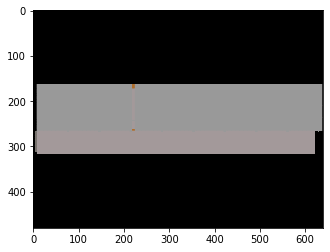

In [5]:
img = pyredner.render_albedo(scene)
# Visualize img
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(img)

Since this model is a room, we only see the exterior of the room. Let's try to peek into the room. Redner's camera pose (or in the computer vision term, the "extrinsic matrix") can be specified in two ways. First, we can specify the [look at transformation](https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/lookat-function) of the camera by specifying the position of the camera (`camera.position`), the position the camera is looking at (`camera.look_at`), and the up vector (`camera.up`). Alternatively, we can directly specify the 4x4 transformation matrix that maps from the camera space to the world space (`camera.cam_to_world`). `pyredner.automatic_camera_placement` uses the look at transform, so we will modify that.

In [6]:
print(camera.position)
print(camera.look_at)
print(camera.up)

tf.Tensor([  332.8403    323.75006 -4322.017  ], shape=(3,), dtype=float32)
tf.Tensor([ 332.8403   323.75006 -193.58344], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


In [0]:
camera.position = camera.look_at + tf.constant([-200.0, 100.0, -700.0])

Scene construction, time: 0.06362 s
Forward pass, time: 0.07688 s


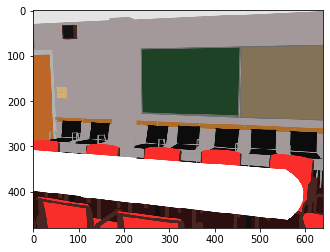

In [8]:
scene = pyredner.Scene(camera = camera, objects = objects)
img = pyredner.render_albedo(scene)
imshow(img)

Looks better. We can also play with the [field of view](https://en.wikipedia.org/wiki/Field_of_view) of the camera to make the view wider.

Scene construction, time: 0.05988 s
Forward pass, time: 0.07042 s


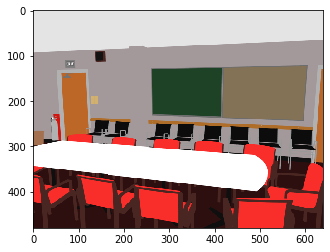

In [9]:
camera.fov = tf.constant([60.0])
scene = pyredner.Scene(camera = camera, objects = objects)
img = pyredner.render_albedo(scene)
imshow(img)

The field of view is one of the "intrinsic" parameters of a camera. There are other parameters such as the camera [skew](https://ksimek.github.io/2013/08/13/intrinsic/). It is common in computer vision community to encapsulate these parameters in a matrix called camera intrinsic matrix. Redner allows one to customize the intrinsic matrix by passing an `intrinsic_mat` parameter to the camera. 

Scene construction, time: 0.05886 s
Forward pass, time: 0.06230 s


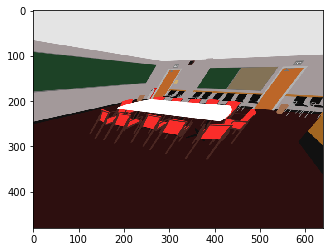

In [10]:
# Construct a 3x3 intrinsic matrix
# fx,  s, x0
#  0, fy, y0
#  0,  0,  1
# usually functioning cameras don't have skew this significant...
intrinsic_mat = pyredner.generate_intrinsic_mat(fx = tf.constant([0.75]),
                                                fy = tf.constant([0.75]),
                                                skew = tf.constant([0.5]),
                                                x0 = tf.constant([0.2]),
                                                y0 = tf.constant([0.2]))
scene.camera.intrinsic_mat = intrinsic_mat
img = pyredner.render_albedo(scene)
imshow(img)
scene.camera.intrinsic_mat = None

So far we have been using the [perspective camera model](https://en.wikipedia.org/wiki/3D_projection#Perspective_projection). Redner also supports three other kinds of camera models -- orthographic, fisheye, and panorama. We can change the type of camera by changing `camera.camera_type`.

Scene construction, time: 0.06285 s
Forward pass, time: 0.05033 s


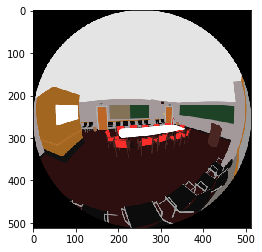

In [11]:
# Fisheye camera with 180 degree field of view
scene.camera.camera_type = pyredner.camera_type.fisheye
scene.camera.resolution = (512, 512)
img = pyredner.render_albedo(scene)
imshow(img)

Scene construction, time: 0.06025 s
Forward pass, time: 0.02963 s


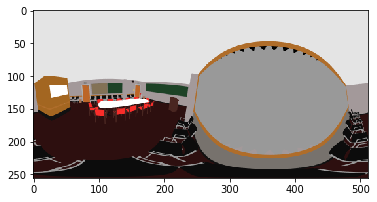

In [12]:
# 360 degree panorama camera
scene.camera.camera_type = pyredner.camera_type.panorama
scene.camera.resolution = (256, 512)
img = pyredner.render_albedo(scene)
imshow(img) # gamma tone compression

Scene construction, time: 0.05881 s
Forward pass, time: 0.06355 s


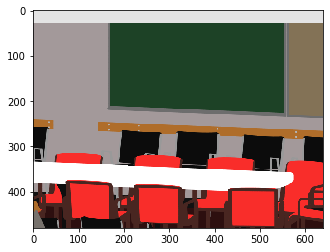

In [13]:
# Orthographic camera
# For orthographic cameras we need to use the cam_to_world transform to scale the view, otherwise we wouldn't see much.
scene.camera.camera_type = pyredner.camera_type.orthographic
scene.camera.resolution = (480, 640)
scene.camera.cam_to_world = pyredner.gen_look_at_matrix(scene.camera.position,
                                                       scene.camera.look_at,
                                                       scene.camera.up) @ pyredner.gen_scale_matrix(tf.ones(3) * 600.0)
img = pyredner.render_albedo(scene)
imshow(img)

All cameras are compatible with other rendering modes. You can render with the physically-based rendering mode for example.

Scene construction, time: 0.20358 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Forward pass, time: 11.10244 s


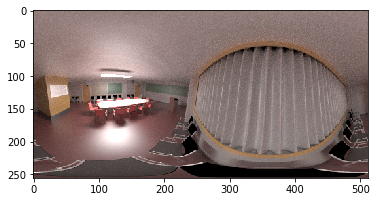

In [14]:
scene.camera.camera_type = pyredner.camera_type.panorama
scene.camera.resolution = (256, 512)
scene.camera.cam_to_world = None
# The scene doesn't have a light source. We will generate one.
light = pyredner.generate_quad_light(position = camera.look_at + tf.constant([0.0, 250.0, 0.0]),
                                     look_at = camera.look_at,
                                     size = tf.constant([400.0, 100.0]),
                                     intensity = tf.constant([50.0, 50.0, 50.0]))
scene = pyredner.Scene(camera = camera, objects = objects + [light])
img = pyredner.render_pathtracing(scene, num_samples=(512, 16), max_bounces=8)
imshow(tf.pow(img, 1.0/2.2)) # gamma tone compression